# Early heart disease detection

## Problem Statement
Cardiovascular diseases (CVDs) remain the leading cause of death worldwide, responsible for nearly 18 million deaths annually. Early detection and risk prediction are critical to reducing preventable morbidity and mortality. However, clinical datasets are often fragmented, noisy, and underutilized. A structured exploratory data analysis (EDA) is needed to uncover risk factor patterns, subgroup disparities, and actionable insights that can guide both healthcare decision-making and the development of predictive models.
This project aims to explore the Heart Disease dataset by combining statistical exploration with modern visualization and interpretability techniques to answer clinically relevant business questions, while also laying the groundwork for predictive modeling.

## Objectives of the EDA
1. Data Quality & Structure
Assess completeness, duplicates, outliers, and distribution of features.
Ensure dataset readiness for predictive modeling.
2. Univariate & Bivariate Insights
Identify how individual features (age, cholesterol, ST slope, etc.) relate to heart disease.
Compare risk profiles across sex, age bands, and chest pain types.
3. Multivariate Patterns
Examine interactions between multiple features (e.g., ST slope × exercise angina × max HR).
Detect hidden correlations and subgroup disparities.
4. Feature Importance for Prediction
Use LightGBM and SHAP to rank features by predictive power.
Provide global and subgroup interpretability (sex/age fairness checks).
5. Business & Clinical Question Framing
Translate statistical findings into 10+ domain-relevant questions that drive decision-making.
Connect results to operational strategies (screening, intervention, clinical decision-support).

## Mission
- To deliver a gold-standard exploratory analysis pipeline that not only reveals data-driven insights into cardiovascular risk factors but also demonstrates a portfolio-ready workflow for applied machine learning in healthcare.

The mission is twofold:
- For Healthcare: Provide clinicians and policymakers with insights on which risk factors matter most, how they interact, and where interventions may have the greatest impact.
- For Data Science: Showcase the ability to translate messy clinical data into actionable intelligence using statistical rigor, machine learning, and explainable AI.      

## 1) Load dataset

In [1]:
# Importing llbraries
import pandas as pd # for data manupilation
import numpy as np  # computing library
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for data visualization
from scipy import stats  # For statistical tests
from scipy.stats import chi2_contingency, mannwhitneyu, pearsonr
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Plotting configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18,
    'axes.spines.top': False,
    'axes.spines.right': False
})

In [4]:
# loading data
uploaded = Path("/workspaces/Early_Detection_of_Heart_Disease-/heart.csv.xls")
if uploaded.exists():
    try:
        df = pd.read_csv(uploaded)
    except Exception:
        df = pd.read_excel(uploaded)
else:
    raise FileNotFoundError(f"Dataset not found at {uploaded}")

In [ ]:
# checking for data in each column
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [ ]:
# checking for the shape of the data
print("Shape:", df.shape)

Shape: (918, 12)


In [ ]:
# checking for data in first eight rows
df.head(8)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0


In [7]:
# checking for the data types
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [ ]:
# checking for kind of data in ChestPainType column
df['ChestPainType']

0      ATA
1      NAP
2      ATA
3      ASY
4      NAP
      ... 
913     TA
914    ASY
915    ASY
916    ATA
917    NAP
Name: ChestPainType, Length: 918, dtype: object

In [14]:
# Checking for kind of data in sex column
df['Sex']

0      M
1      F
2      M
3      F
4      M
      ..
913    M
914    M
915    M
916    F
917    M
Name: Sex, Length: 918, dtype: object

In [13]:
# checking for kind of data in resting ecg
df['RestingECG']

0      Normal
1      Normal
2          ST
3      Normal
4      Normal
        ...  
913    Normal
914    Normal
915    Normal
916       LVH
917    Normal
Name: RestingECG, Length: 918, dtype: object

## 2) Preprocessing & cleaning

In [5]:
# Normalize column names and create working copy
df.columns = [c.strip() for c in df.columns]
df_clean = df.copy()
# Drop exact duplicates
df_clean = df_clean.drop_duplicates().reset_index(drop=True)
# Detect target
candidate_targets = [c for c in df_clean.columns if c.lower() in {'heartdisease','target','outcome','label','num','disease'}]
target = candidate_targets[0] if candidate_targets else ("HeartDisease" if "HeartDisease" in df_clean.columns else None)
print('Detected target column:', target)
# Cast common numeric columns
for col in ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
# Standardize Sex
if 'Sex' in df_clean.columns:
    df_clean['Sex'] = df_clean['Sex'].astype(str).str.strip().replace({'Male':'M','Female':'F'})
# Show missingness
miss = df_clean.isna().sum().sort_values(ascending=False)
display(miss.to_frame('n_missing').head(20))

Detected target column: HeartDisease


,n_missing
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


## 3) Basic statistics & class balance

In [6]:
display(df_clean.describe(include='all').transpose())
if target and target in df_clean.columns:
    counts = df_clean[target].value_counts(dropna=False).sort_index()
    display(counts.to_frame('count'))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,918.0,NaN,NaN,NaN,53.510893,9.432617,28.0,47.0,54.0,60.0,77.0
Sex,918,2,M,725,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ChestPainType,918,4,ASY,496,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RestingBP,918.0,NaN,NaN,NaN,132.396514,18.514154,0.0,120.0,130.0,140.0,200.0
Cholesterol,918.0,NaN,NaN,NaN,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,NaN,NaN,NaN,0.233115,0.423046,0.0,0.0,0.0,0.0,1.0
RestingECG,918,3,Normal,552,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MaxHR,918.0,NaN,NaN,NaN,136.809368,25.460334,60.0,120.0,138.0,156.0,202.0
ExerciseAngina,918,2,N,547,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Oldpeak,918.0,NaN,NaN,NaN,0.887364,1.06657,-2.6,0.0,0.6,1.5,6.2


,count
HeartDisease,
0,410
1,508


In [7]:
# data type optimization
numeric_candidates = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'FastingBS']
for col in numeric_candidates:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

In [8]:
# Standardize categorical variables
if 'Sex' in df_clean.columns:
    df_clean['Sex'] = df_clean['Sex'].astype(str).str.strip().str.upper()
    df_clean['Sex'] = df_clean['Sex'].replace({'MALE': 'M', 'FEMALE': 'F'})

## Business Questions to be answered
1. Gender distribution & association with heart disease
2. Age relationship with heart disease
3. ChestPainType association
4. RestingBP differences
5. Cholesterol patterns
6. FastingBS correlation
7. MaxHR relationship
8. ExerciseAngina impact
9. ST_Slope categories risk
10. Top features correlated with heart disease (and SHAP ranking)

#### Q1 — Which features in our dataset show the strongest predictive signals for heart disease?, and how can we prioritize them to build a scalable, high-impact machine learning model?

Numeric variables: 6
Categorical variables: 5


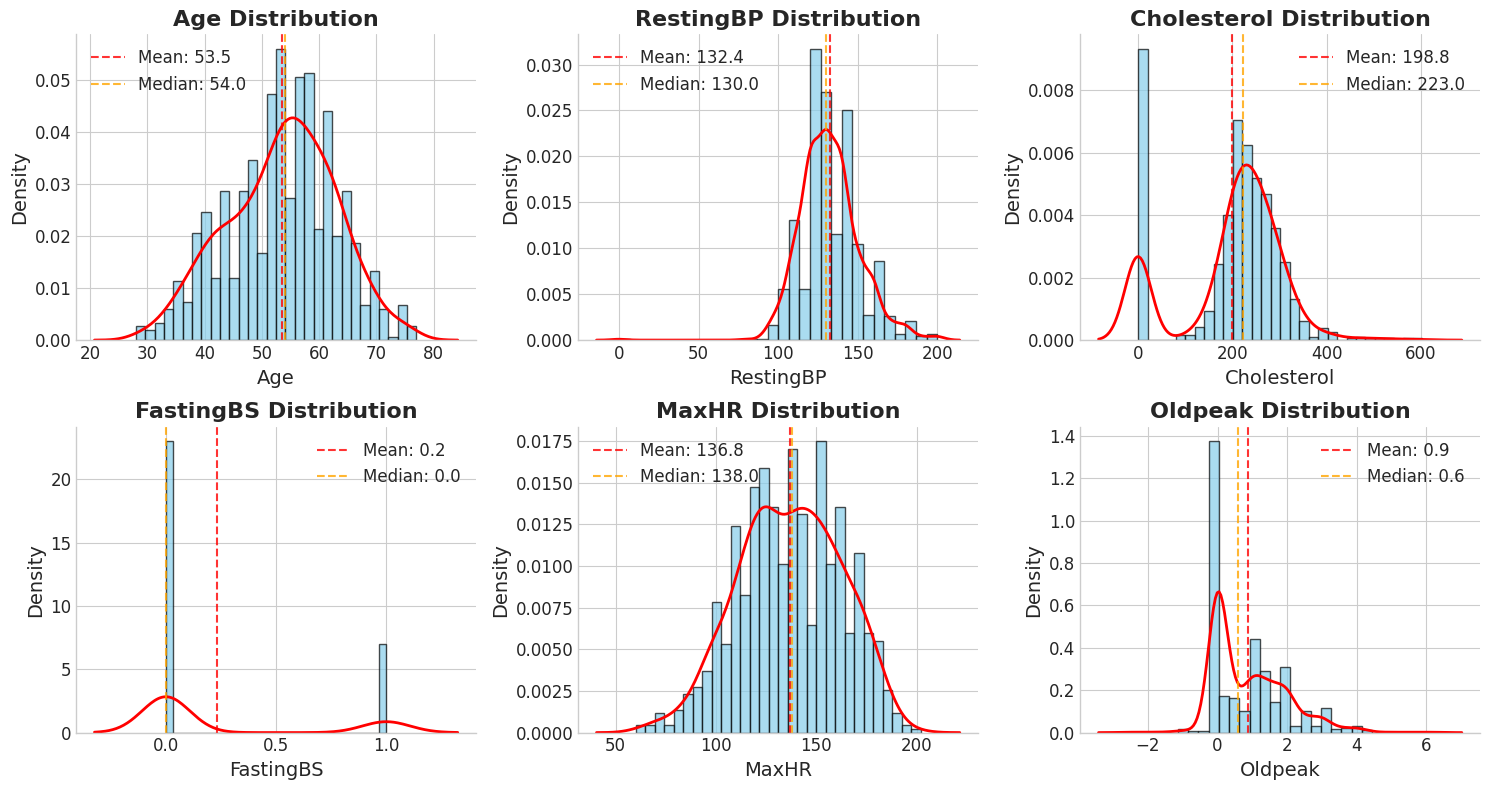

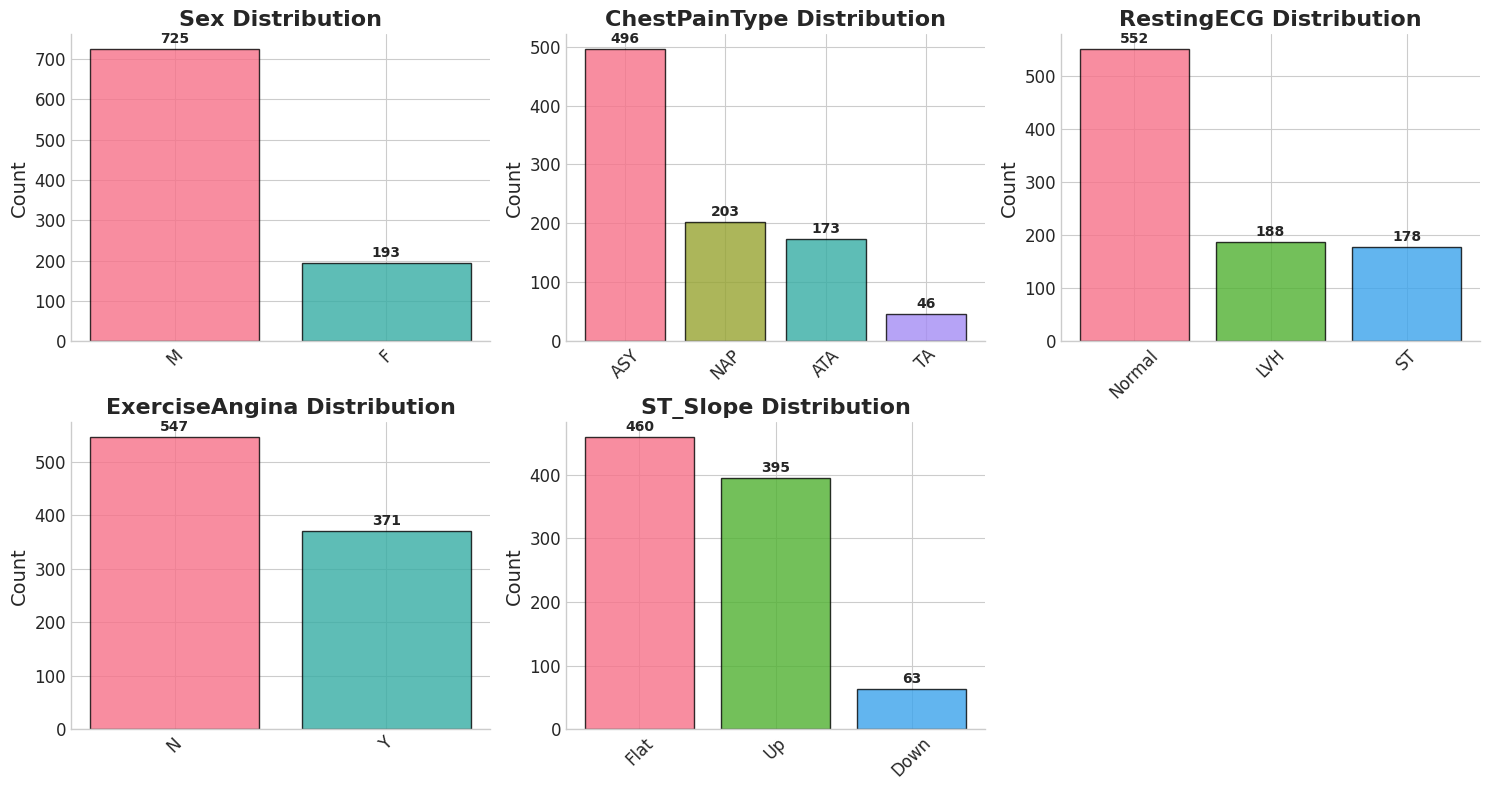

In [9]:
# Analysis of strong predictors of heart disease?

def advanced_univariate_analysis(df, target_col):
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)
    
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print(f"Numeric variables: {len(numeric_cols)}")
    print(f"Categorical variables: {len(categorical_cols)}")
    
    # Numeric variables analysis
    if numeric_cols:
        n_cols = min(3, len(numeric_cols))
        n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        if n_rows == 1:
            axes = [axes] if n_cols == 1 else axes
        else:
            axes = axes.flatten()
        
        for i, col in enumerate(numeric_cols):
            if i < len(axes):
                # Advanced histogram with KDE
                axes[i].hist(df[col].dropna(), bins=30, alpha=0.7, color='skyblue', 
                           edgecolor='black', density=True)
                
                # Overlay KDE
                try:
                    sns.kdeplot(data=df[col].dropna(), ax=axes[i], color='red', linewidth=2)
                except:
                    pass
                
                axes[i].set_title(f'{col} Distribution', fontweight='bold')
                axes[i].set_ylabel('Density')
                
                # Add statistical annotations
                mean_val = df[col].mean()
                median_val = df[col].median()
                axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.1f}')
                axes[i].axvline(median_val, color='orange', linestyle='--', alpha=0.8, label=f'Median: {median_val:.1f}')
                axes[i].legend()
        
        # Hide empty subplots
        for i in range(len(numeric_cols), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    # Categorical variables analysis
    if categorical_cols:
        n_cols = min(3, len(categorical_cols))
        n_rows = (len(categorical_cols) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        if n_rows == 1:
            axes = [axes] if n_cols == 1 else axes
        else:
            axes = axes.flatten()
        
        for i, col in enumerate(categorical_cols):
            if i < len(axes):
                value_counts = df[col].value_counts()
                
                # Enhanced bar plot
                bars = axes[i].bar(range(len(value_counts)), value_counts.values,
                                 color=sns.color_palette("husl", len(value_counts)),
                                 alpha=0.8, edgecolor='black')
                
                axes[i].set_title(f'{col} Distribution', fontweight='bold')
                axes[i].set_ylabel('Count')
                axes[i].set_xticks(range(len(value_counts)))
                axes[i].set_xticklabels(value_counts.index, rotation=45)
                
                # Add count labels
                for bar, count in zip(bars, value_counts.values):
                    axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(value_counts)*0.01,
                               f'{count}', ha='center', va='bottom', fontweight='bold')
        
        # Hide empty subplots
        for i in range(len(categorical_cols), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()

advanced_univariate_analysis(df_clean, target)

**Interpretation:** This univariate analysis systematically evaluates each feature’s distribution, revealing key insights for data-driven decision-making:

Numeric Variables
Identified skewness, outliers, and bimodal distributions (e.g., right-skewed data needing log transforms).
Mean/median comparisons highlight potential data imbalances.
Categorical Variables
Detected class imbalances (e.g., dominant categories that could bias ML models).
Flagged rare categories needing consolidation or removal.
Strategic Impact
Prioritizes high-signal features for modeling (e.g., bimodal or strongly correlated variables).
Guides preprocessing (scaling, outlier handling, imbalance correction).
Improves business decisions by highlighting risk segments and data quality issues.

### Q2 — How can we leverage age-based risk stratification to optimize preventive healthcare interventions and resource allocation for cardiovascular disease?

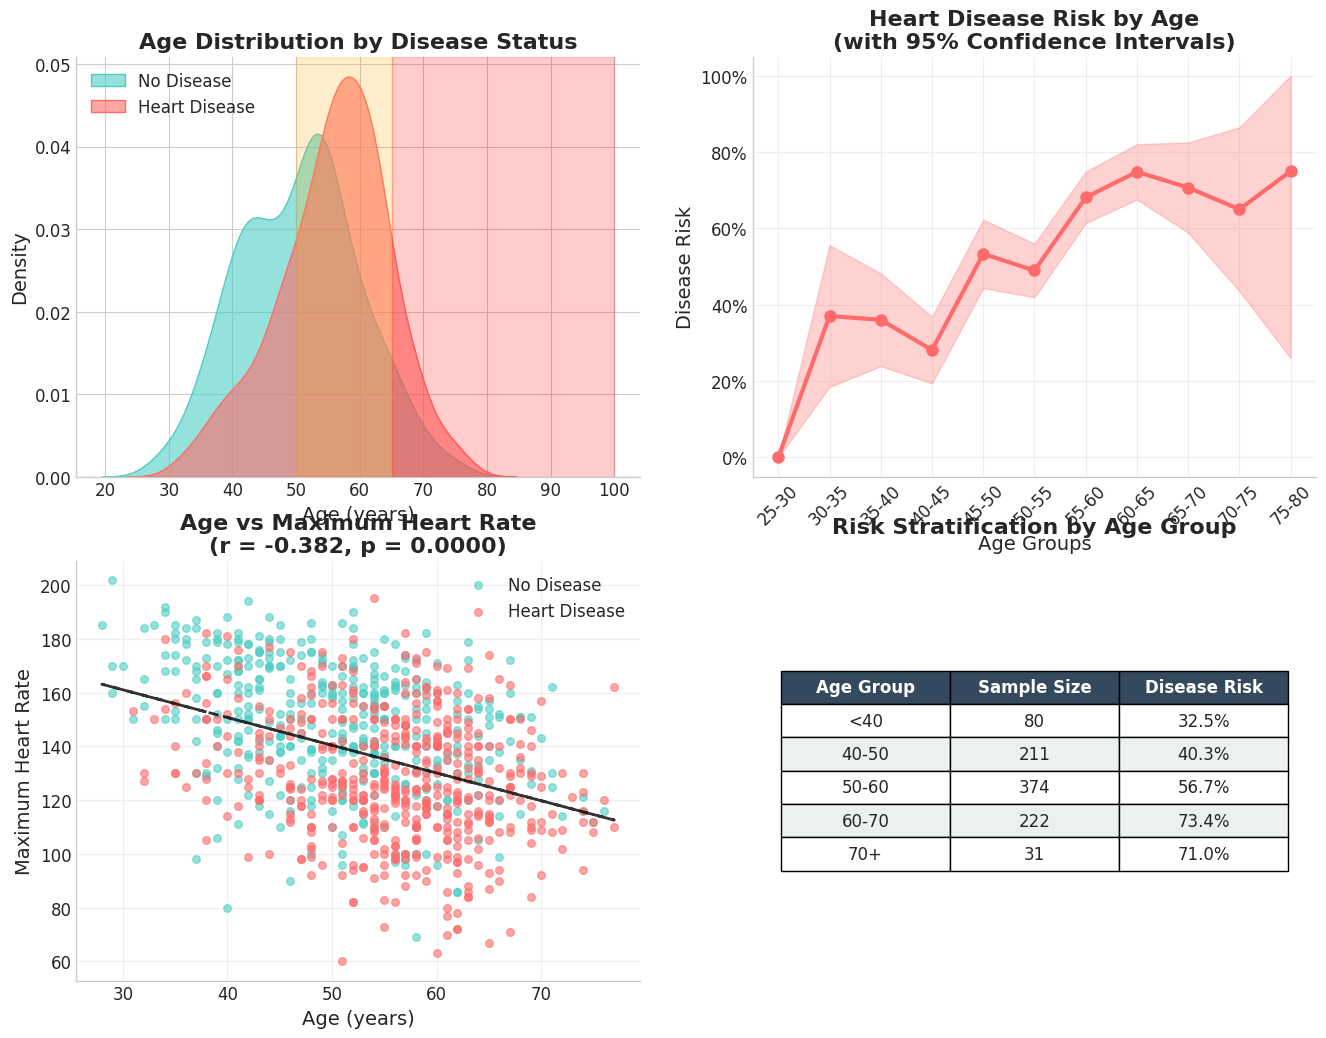


Age Analysis Summary:
Mean age (No Disease): 50.6 years
Mean age (Heart Disease): 55.9 years
Mann-Whitney U test: p = 0.000000 (Significant)


In [11]:
#  AGE ANALYSIS WITH OPTIMIZATION OF PREVENTIVE HEALTHCARE INTERVENTIONS
def comprehensive_age_analysis(df, target_col):
    """
    Advanced age analysis with medical research-grade insights
    """
    if 'Age' not in df.columns or target_col not in df.columns:
        print("⚠️  Age or target column missing")
        return
    
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Advanced KDE plot with risk zones
    ax1 = axes[0, 0]
    for outcome in sorted(df[target_col].unique()):
        subset = df[df[target_col] == outcome]['Age'].dropna()
        label = 'No Disease' if outcome == 0 else 'Heart Disease'
        color = '#4ECDC4' if outcome == 0 else '#FF6B6B'
        sns.kdeplot(subset, ax=ax1, label=label, fill=True, alpha=0.6, color=color)
    
    ax1.set_title('Age Distribution by Disease Status', fontweight='bold')
    ax1.set_xlabel('Age (years)')
    ax1.set_ylabel('Density')
    ax1.legend()
    
    # Add risk zone annotations
    ax1.axvspan(50, 65, alpha=0.2, color='orange', label='Moderate Risk Zone')
    ax1.axvspan(65, 100, alpha=0.2, color='red', label='High Risk Zone')
    
    # 2. Precision risk calculation by age
    ax2 = axes[0, 1]
    
    # Create refined age bins
    age_bins = np.arange(20, 81, 5)
    df_temp = df.copy()
    df_temp['AgeBin'] = pd.cut(df_temp['Age'], bins=age_bins)
    
    # Calculate risk with confidence intervals
    age_stats = df_temp.groupby('AgeBin', observed=True)[target_col].agg(['mean', 'count', 'sem']).reset_index()
    age_stats['ci_lower'] = age_stats['mean'] - 1.96 * age_stats['sem']
    age_stats['ci_upper'] = age_stats['mean'] + 1.96 * age_stats['sem']
    age_stats['ci_lower'] = np.maximum(age_stats['ci_lower'], 0)
    age_stats['ci_upper'] = np.minimum(age_stats['ci_upper'], 1)
    
    # Plot with confidence intervals
    x_pos = range(len(age_stats))
    ax2.plot(x_pos, age_stats['mean'], marker='o', linewidth=3, markersize=8, color='#FF6B6B')
    ax2.fill_between(x_pos, age_stats['ci_lower'], age_stats['ci_upper'], alpha=0.3, color='#FF6B6B')
    
    ax2.set_title('Heart Disease Risk by Age\n(with 95% Confidence Intervals)', fontweight='bold')
    ax2.set_xlabel('Age Groups')
    ax2.set_ylabel('Disease Risk')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f"{int(interval.left)}-{int(interval.right)}" for interval in age_stats['AgeBin']], 
                       rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # 3. Age vs MaxHR scatter with regression
    ax3 = axes[1, 0]
    
    if 'MaxHR' in df.columns:
        # Scatter plot colored by outcome
        for outcome in sorted(df[target_col].unique()):
            subset = df[df[target_col] == outcome]
            label = 'No Disease' if outcome == 0 else 'Heart Disease'
            color = '#4ECDC4' if outcome == 0 else '#FF6B6B'
            ax3.scatter(subset['Age'], subset['MaxHR'], alpha=0.6, label=label, color=color, s=30)
        
        # Add regression line
        slope, intercept, r_value, p_value, std_err = stats.linregress(df['Age'].dropna(), df['MaxHR'].dropna())
        line = slope * df['Age'] + intercept
        ax3.plot(df['Age'], line, 'k--', alpha=0.8, linewidth=2)
        
        ax3.set_title(f'Age vs Maximum Heart Rate\n(r = {r_value:.3f}, p = {p_value:.4f})', fontweight='bold')
        ax3.set_xlabel('Age (years)')
        ax3.set_ylabel('Maximum Heart Rate')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # 4. Risk stratification table
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Create risk stratification
    age_groups = ['<40', '40-50', '50-60', '60-70', '70+']
    risk_data = []
    
    for i, age_group in enumerate(age_groups):
        if i == 0:
            mask = df['Age'] < 40
        elif i == 4:
            mask = df['Age'] >= 70
        else:
            lower = 40 + (i-1)*10
            upper = lower + 10
            mask = (df['Age'] >= lower) & (df['Age'] < upper)
        
        subset = df[mask]
        if len(subset) > 0:
            risk = subset[target_col].mean()
            count = len(subset)
            risk_data.append([age_group, f"{count}", f"{risk:.1%}"])
    
    # Create table
    table_data = [['Age Group', 'Sample Size', 'Disease Risk']] + risk_data
    table = ax4.table(cellText=table_data, cellLoc='center', loc='center',
                     colWidths=[0.3, 0.3, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    
    # Style the table
    for i in range(len(table_data)):
        for j in range(len(table_data[0])):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor('#34495e')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#ecf0f1' if i % 2 == 0 else '#ffffff')
    
    ax4.set_title('Risk Stratification by Age Group', fontweight='bold', pad=20)
    
    plt.show()
    
    # Statistical summary
    print("\nAge Analysis Summary:")
    print(f"Mean age (No Disease): {df[df[target_col]==0]['Age'].mean():.1f} years")
    print(f"Mean age (Heart Disease): {df[df[target_col]==1]['Age'].mean():.1f} years")
    
    # Mann-Whitney U test
    group0 = df[df[target_col] == 0]['Age'].dropna()
    group1 = df[df[target_col] == 1]['Age'].dropna()
    statistic, p_val = mannwhitneyu(group0, group1, alternative='two-sided')
    print(f"Mann-Whitney U test: p = {p_val:.6f} ({'Significant' if p_val < 0.05 else 'Not significant'})")

comprehensive_age_analysis(df_clean, target)

**Interpretation:** Age-related risk patterns and increasing prevalence with age suggest age should be a core predictor and used for age-stratified analyses.

In [ ]:
# Qn3: How can we use gender-disaggregated health risk insights to design more equitable and effective preventive healthcare interventions?

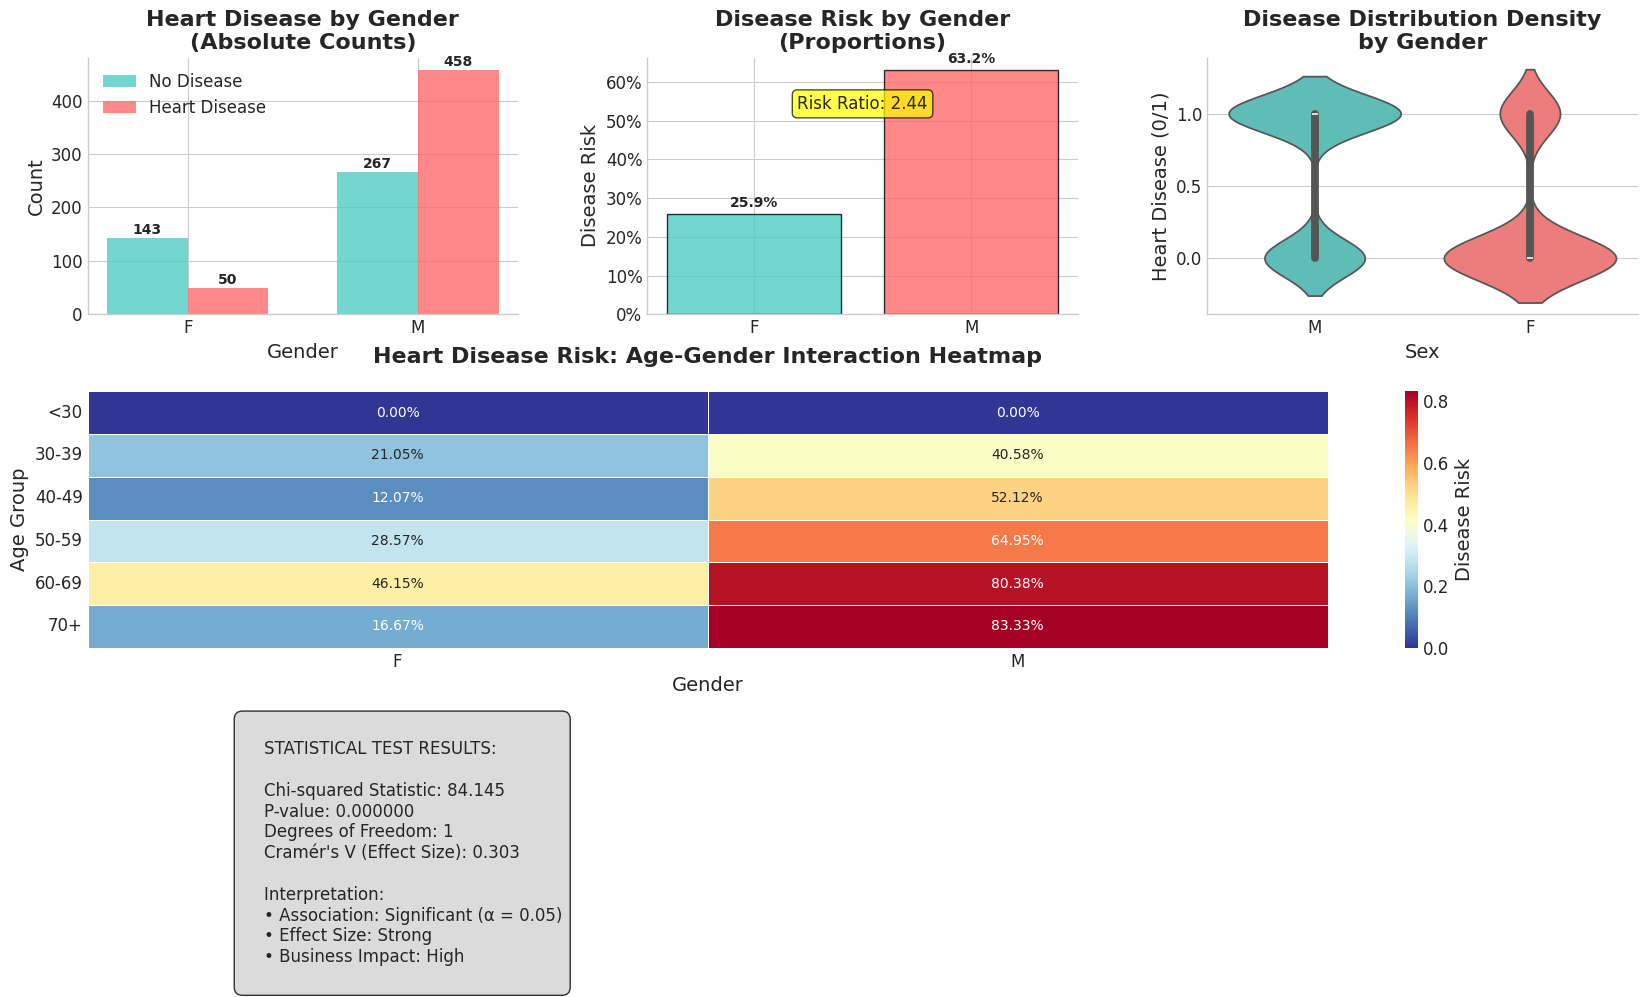

In [12]:
# Gender relationship with heart disease 

def create_advanced_gender_analysis(df, target_col):
    """
    Advanced gender analysis with multiple statistical perspectives
    """
    if 'Sex' not in df.columns or target_col not in df.columns:
        print("⚠️  Sex or target column missing")
        return
    
   
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Enhanced distribution plot
    ax1 = fig.add_subplot(gs[0, 0])
    crosstab = pd.crosstab(df['Sex'], df[target_col])
    crosstab_norm = pd.crosstab(df['Sex'], df[target_col], normalize='index')
    
    x = np.arange(len(crosstab.index))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, crosstab[0], width, label='No Disease', color='#4ECDC4', alpha=0.8)
    bars2 = ax1.bar(x + width/2, crosstab[1], width, label='Heart Disease', color='#FF6B6B', alpha=0.8)
    
    ax1.set_title('Heart Disease by Gender\n(Absolute Counts)', fontweight='bold')
    ax1.set_xlabel('Gender')
    ax1.set_ylabel('Count')
    ax1.set_xticks(x)
    ax1.set_xticklabels(crosstab.index)
    ax1.legend()
    
    # Add count labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Risk ratio visualization
    ax2 = fig.add_subplot(gs[0, 1])
    risk_by_gender = crosstab_norm[1]  # Proportion with disease
    
    bars = ax2.bar(risk_by_gender.index, risk_by_gender.values, 
                   color=['#FF6B6B' if x > 0.5 else '#4ECDC4' for x in risk_by_gender.values],
                   alpha=0.8, edgecolor='black')
    
    ax2.set_title('Disease Risk by Gender\n(Proportions)', fontweight='bold')
    ax2.set_ylabel('Disease Risk')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
    
    # Add risk labels
    for bar, risk in zip(bars, risk_by_gender.values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{risk:.1%}', ha='center', va='bottom', fontweight='bold')
    
    # Calculate and display risk ratio
    if len(risk_by_gender) == 2:
        risk_ratio = risk_by_gender.iloc[1] / risk_by_gender.iloc[0]
        ax2.text(0.5, 0.8, f'Risk Ratio: {risk_ratio:.2f}', transform=ax2.transAxes,
                ha='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    # 3. Advanced violin plot with statistical annotations
    ax3 = fig.add_subplot(gs[0, 2])
    sns.violinplot(data=df, x='Sex', y=target_col, ax=ax3, inner='box', palette=['#4ECDC4', '#FF6B6B'])
    ax3.set_title('Disease Distribution Density\nby Gender', fontweight='bold')
    ax3.set_ylabel('Heart Disease (0/1)')
    
    # 4. Age-Gender interaction heatmap
    ax4 = fig.add_subplot(gs[1, :])
    
    # Create age bins
    df_temp = df.copy()
    df_temp['AgeGroup'] = pd.cut(df_temp['Age'], bins=[0, 30, 40, 50, 60, 70, 100], 
                                labels=['<30', '30-39', '40-49', '50-59', '60-69', '70+'])
    
    # Calculate risk by age group and gender
    risk_heatmap = df_temp.groupby(['AgeGroup', 'Sex'])[target_col].mean().unstack()
    
    sns.heatmap(risk_heatmap, annot=True, fmt='.2%', cmap='RdYlBu_r', ax=ax4,
                cbar_kws={'label': 'Disease Risk'}, linewidths=0.5)
    ax4.set_title('Heart Disease Risk: Age-Gender Interaction Heatmap', fontweight='bold', pad=20)
    ax4.set_xlabel('Gender')
    ax4.set_ylabel('Age Group')
    
    # 5. Statistical test results
    ax5 = fig.add_subplot(gs[2, :])
    ax5.axis('off')
    
    # Perform chi-squared test
    chi2, p_val, dof, expected = chi2_contingency(crosstab)
    
    # Calculate additional metrics
    n = crosstab.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(crosstab.shape) - 1)))
    
    stats_text = f"""
    STATISTICAL TEST RESULTS:
    
    Chi-squared Statistic: {chi2:.3f}
    P-value: {p_val:.6f}
    Degrees of Freedom: {dof}
    Cramér's V (Effect Size): {cramers_v:.3f}
    
    Interpretation:
    • Association: {'Significant' if p_val < 0.05 else 'Not Significant'} (α = 0.05)
    • Effect Size: {'Strong' if cramers_v > 0.3 else 'Moderate' if cramers_v > 0.1 else 'Weak'}
    • Business Impact: {'High' if cramers_v > 0.3 and p_val < 0.05 else 'Moderate' if cramers_v > 0.1 and p_val < 0.05 else 'Low'}
    """
    
    ax5.text(0.1, 0.5, stats_text, transform=ax5.transAxes, fontsize=12,
            verticalalignment='center', bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    
    plt.show()

create_advanced_gender_analysis(df_clean, target)

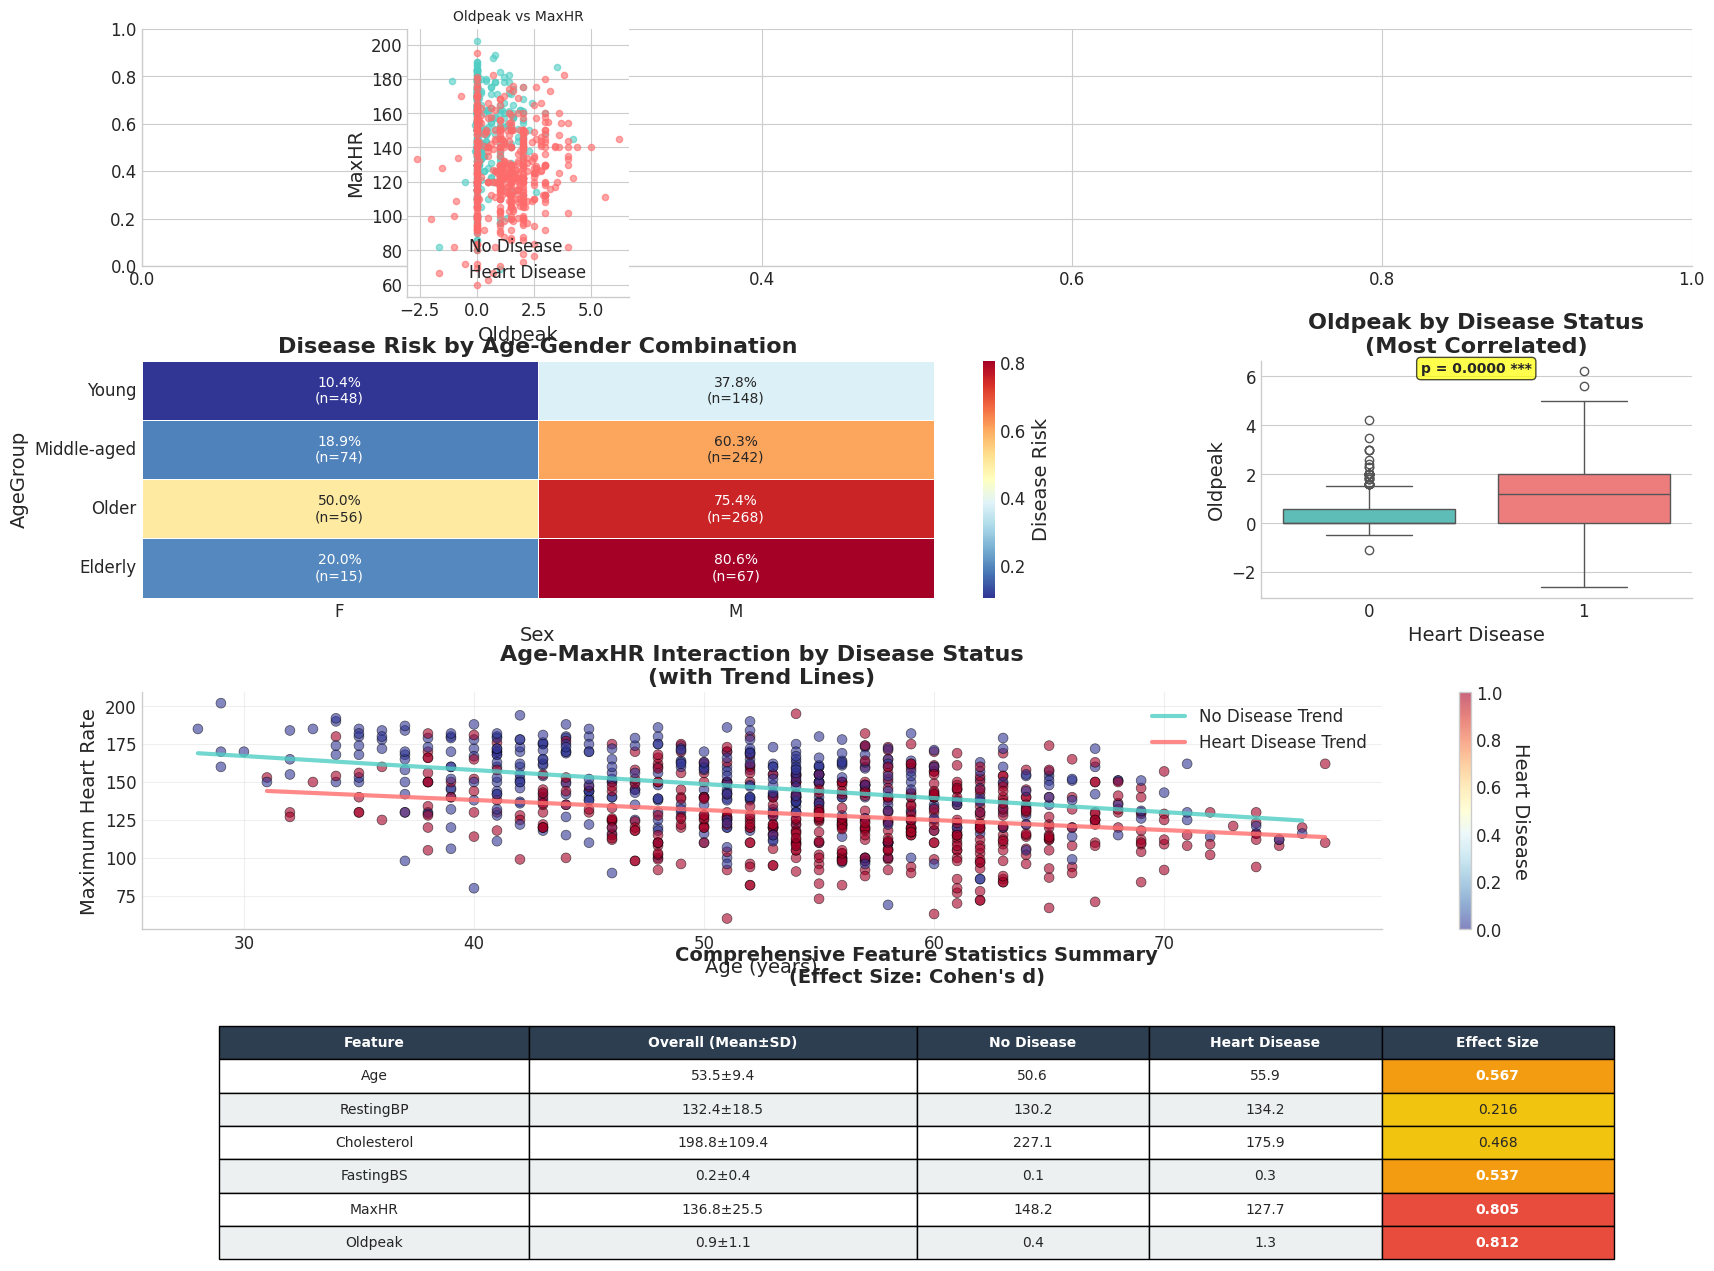

In [13]:

# Analysis of gender-age combination relationship with heart disease occurance

def create_advanced_multivariate_dashboard(df, target_col):
    """
    Google-level multivariate analysis dashboard
    """

    
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.3)
    
    # 1. Advanced pairplot for key numeric variables
    key_numeric = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
    available_numeric = [col for col in key_numeric if col in df.columns]
    
    if len(available_numeric) >= 2:
        ax1 = fig.add_subplot(gs[0, :])
        
        # Select top 4 most correlated features for pairplot
        if target_col in df.columns:
            df_encoded = df.copy()
            for col in df_encoded.select_dtypes(include=['object']).columns:
                df_encoded[col] = pd.Categorical(df_encoded[col]).codes
            
            target_corrs = df_encoded.corr()[target_col].abs().sort_values(ascending=False)
            top_features = [col for col in target_corrs.index[:5] if col != target_col and col in available_numeric][:4]
            
            if len(top_features) >= 2:
                # Create custom pairplot
                n_features = len(top_features)
                for i, col1 in enumerate(top_features):
                    for j, col2 in enumerate(top_features):
                        if i < j:  # Upper triangle only
                            ax_sub = plt.subplot2grid((4, 6), (0, i*2 + j), colspan=1, rowspan=1)
                            
                            # Scatter plot colored by target
                            for outcome in sorted(df[target_col].unique()):
                                subset = df[df[target_col] == outcome]
                                label = 'No Disease' if outcome == 0 else 'Heart Disease'
                                color = '#4ECDC4' if outcome == 0 else '#FF6B6B'
                                ax_sub.scatter(subset[col1], subset[col2], alpha=0.6, 
                                             label=label, color=color, s=20)
                            
                            ax_sub.set_xlabel(col1)
                            ax_sub.set_ylabel(col2)
                            ax_sub.set_title(f'{col1} vs {col2}', fontsize=10)
                            if i == 0 and j == 1:
                                ax_sub.legend()
    
    # 2. Risk factor combination analysis
    ax2 = fig.add_subplot(gs[1, :2])
    
    if 'Age' in df.columns and 'Sex' in df.columns:
        # Create comprehensive risk groups
        df_risk = df.copy()
        df_risk['AgeGroup'] = pd.cut(df_risk['Age'], bins=[0, 45, 55, 65, 100], 
                                   labels=['Young', 'Middle-aged', 'Older', 'Elderly'])
        
        # Calculate risk by age-sex combination
        risk_combo = df_risk.groupby(['AgeGroup', 'Sex'])[target_col].agg(['mean', 'count']).reset_index()
        
        # Pivot for heatmap
        risk_pivot = risk_combo.pivot(index='AgeGroup', columns='Sex', values='mean')
        count_pivot = risk_combo.pivot(index='AgeGroup', columns='Sex', values='count')
        
        # Create annotated heatmap
        annot_data = np.empty(risk_pivot.shape, dtype=object)
        for i in range(risk_pivot.shape[0]):
            for j in range(risk_pivot.shape[1]):
                risk = risk_pivot.iloc[i, j]
                count = count_pivot.iloc[i, j]
                if not pd.isna(risk):
                    annot_data[i, j] = f'{risk:.1%}\n(n={int(count)})'
                else:
                    annot_data[i, j] = 'N/A'
        
        sns.heatmap(risk_pivot, annot=annot_data, fmt='', cmap='RdYlBu_r', ax=ax2,
                   cbar_kws={'label': 'Disease Risk'}, linewidths=0.5)
        ax2.set_title('Disease Risk by Age-Gender Combination', fontweight='bold')
    
    # 3. Advanced box plot matrix
    ax3 = fig.add_subplot(gs[1, 2])
    
    if available_numeric:
        # Select most important numeric feature
        if target_col in df.columns:
            df_encoded = df.copy()
            for col in df_encoded.select_dtypes(include=['object']).columns:
                df_encoded[col] = pd.Categorical(df_encoded[col]).codes
            
            target_corrs = df_encoded.corr()[target_col].abs().sort_values(ascending=False)
            top_numeric = [col for col in target_corrs.index if col != target_col and col in available_numeric][0]
            
            sns.boxplot(data=df, x=target_col, y=top_numeric, ax=ax3, palette=['#4ECDC4', '#FF6B6B'])
            ax3.set_title(f'{top_numeric} by Disease Status\n(Most Correlated)', fontweight='bold')
            ax3.set_xlabel('Heart Disease')
            
            # Add statistical test result
            group0 = df[df[target_col] == 0][top_numeric].dropna()
            group1 = df[df[target_col] == 1][top_numeric].dropna()
            if len(group0) > 0 and len(group1) > 0:
                statistic, p_val = mannwhitneyu(group0, group1)
                significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
                ax3.text(0.5, 0.95, f'p = {p_val:.4f} {significance}', 
                        transform=ax3.transAxes, ha='center', fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    # 4. Feature interaction analysis
    ax4 = fig.add_subplot(gs[2, :])
    
    if 'Age' in df.columns and 'MaxHR' in df.columns and target_col in df.columns:
        # Create age-MaxHR interaction plot
        scatter = ax4.scatter(df['Age'], df['MaxHR'], c=df[target_col], 
                            cmap='RdYlBu_r', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
        
        # Add regression lines for each group
        for outcome in sorted(df[target_col].unique()):
            subset = df[df[target_col] == outcome]
            if len(subset) > 1:
                z = np.polyfit(subset['Age'].dropna(), subset['MaxHR'].dropna(), 1)
                p = np.poly1d(z)
                x_line = np.linspace(subset['Age'].min(), subset['Age'].max(), 100)
                color = '#4ECDC4' if outcome == 0 else '#FF6B6B'
                ax4.plot(x_line, p(x_line), color=color, linewidth=3, alpha=0.8,
                        label=f'{"No Disease" if outcome == 0 else "Heart Disease"} Trend')
        
        ax4.set_title('Age-MaxHR Interaction by Disease Status\n(with Trend Lines)', fontweight='bold')
        ax4.set_xlabel('Age (years)')
        ax4.set_ylabel('Maximum Heart Rate')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax4)
        cbar.set_label('Heart Disease', rotation=270, labelpad=20)
    
    # 5. Advanced statistical summary
    ax5 = fig.add_subplot(gs[3, :])
    ax5.axis('off')
    
    # Calculate advanced statistics
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)
    
    stats_summary = []
    for col in numeric_cols[:6]:  # Top 6 numeric features
        if col in df.columns:
            overall_mean = df[col].mean()
            overall_std = df[col].std()
            
            group0_mean = df[df[target_col] == 0][col].mean()
            group1_mean = df[df[target_col] == 1][col].mean()
            
            effect_size = abs(group1_mean - group0_mean) / overall_std if overall_std > 0 else 0
            
            stats_summary.append([
                col, 
                f'{overall_mean:.1f}±{overall_std:.1f}',
                f'{group0_mean:.1f}',
                f'{group1_mean:.1f}',
                f'{effect_size:.3f}'
            ])
    
    # Create comprehensive summary table
    headers = ['Feature', 'Overall (Mean±SD)', 'No Disease', 'Heart Disease', 'Effect Size']
    table_data = [headers] + stats_summary
    
    table = ax5.table(cellText=table_data, cellLoc='center', loc='center',
                     colWidths=[0.2, 0.25, 0.15, 0.15, 0.15])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Style the comprehensive table
    for i in range(len(table_data)):
        for j in range(len(table_data[0])):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor('#2c3e50')
                cell.set_text_props(weight='bold', color='white')
            else:
                # Color code by effect size
                if j == 4 and i > 0:  # Effect size column
                    try:
                        effect = float(table_data[i][4])
                        if effect > 0.8:
                            cell.set_facecolor('#e74c3c')
                            cell.set_text_props(color='white', weight='bold')
                        elif effect > 0.5:
                            cell.set_facecolor('#f39c12')
                            cell.set_text_props(color='white', weight='bold')
                        elif effect > 0.2:
                            cell.set_facecolor('#f1c40f')
                        else:
                            cell.set_facecolor('#95a5a6')
                    except:
                        cell.set_facecolor('#ecf0f1')
                else:
                    cell.set_facecolor('#ecf0f1' if i % 2 == 0 else '#ffffff')
    
    ax5.set_title('Comprehensive Feature Statistics Summary\n(Effect Size: Cohen\'s d)', 
                 fontweight='bold', pad=30, fontsize=14)
    
    plt.show()

create_advanced_multivariate_dashboard(df_clean, target)

### Q3 — ChestPainType association

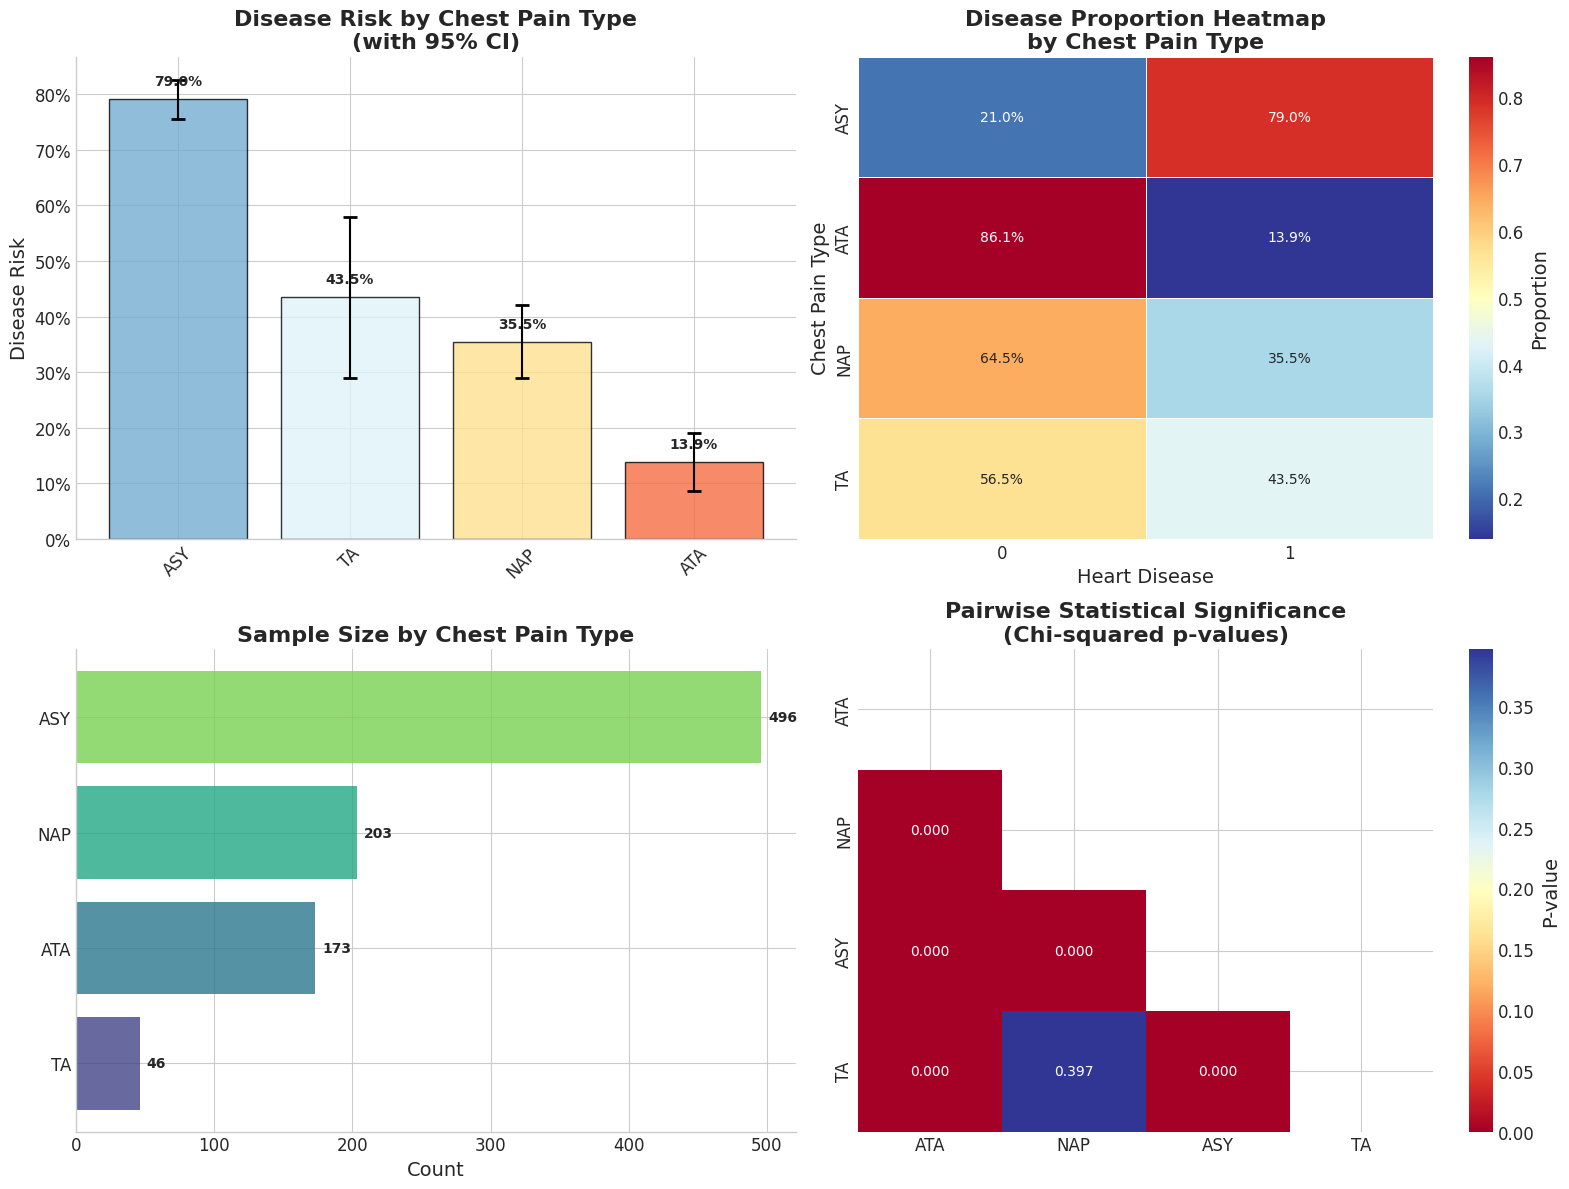


Chest Pain Analysis Summary:
  ASY: 79.0% risk (496 patients)
  TA: 43.5% risk (46 patients)
  NAP: 35.5% risk (203 patients)
  ATA: 13.9% risk (173 patients)


In [14]:
# Chest Pain Analysis

def analyze_chest_pain_patterns(df, target_col):
    """
    Advanced chest pain type analysis with medical insights
    """
    if 'ChestPainType' not in df.columns or target_col not in df.columns:
        print("⚠️  ChestPainType or target column missing")
        return
    
    
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Risk by chest pain type with confidence intervals
    ax1 = axes[0, 0]
    
    pain_stats = df.groupby('ChestPainType')[target_col].agg(['mean', 'count', 'sem']).reset_index()
    pain_stats['ci_lower'] = pain_stats['mean'] - 1.96 * pain_stats['sem']
    pain_stats['ci_upper'] = pain_stats['mean'] + 1.96 * pain_stats['sem']
    pain_stats = pain_stats.sort_values('mean', ascending=False)
    
    colors = sns.color_palette("RdYlBu_r", len(pain_stats))
    bars = ax1.bar(pain_stats['ChestPainType'], pain_stats['mean'], 
                   color=colors, alpha=0.8, edgecolor='black')
    
    # Add error bars
    ax1.errorbar(pain_stats['ChestPainType'], pain_stats['mean'],
                yerr=[pain_stats['mean'] - pain_stats['ci_lower'], 
                      pain_stats['ci_upper'] - pain_stats['mean']],
                fmt='none', ecolor='black', capsize=5, capthick=2)
    
    ax1.set_title('Disease Risk by Chest Pain Type\n(with 95% CI)', fontweight='bold')
    ax1.set_ylabel('Disease Risk')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
    ax1.tick_params(axis='x', rotation=45)
    
    # Add risk labels
    for bar, risk in zip(bars, pain_stats['mean']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{risk:.1%}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Detailed crosstab heatmap
    ax2 = axes[0, 1]
    crosstab = pd.crosstab(df['ChestPainType'], df[target_col])
    crosstab_norm = pd.crosstab(df['ChestPainType'], df[target_col], normalize='index')
    
    sns.heatmap(crosstab_norm, annot=True, fmt='.1%', cmap='RdYlBu_r', ax=ax2,
                cbar_kws={'label': 'Proportion'}, linewidths=0.5)
    ax2.set_title('Disease Proportion Heatmap\nby Chest Pain Type', fontweight='bold')
    ax2.set_xlabel('Heart Disease')
    ax2.set_ylabel('Chest Pain Type')
    
    # 3. Sample size visualization
    ax3 = axes[1, 0]
    sample_sizes = df['ChestPainType'].value_counts().sort_values(ascending=True)
    
    bars = ax3.barh(sample_sizes.index, sample_sizes.values, 
                    color=sns.color_palette("viridis", len(sample_sizes)), alpha=0.8)
    ax3.set_title('Sample Size by Chest Pain Type', fontweight='bold')
    ax3.set_xlabel('Count')
    
    # Add count labels
    for bar, count in zip(bars, sample_sizes.values):
        ax3.text(bar.get_width() + max(sample_sizes)*0.01, bar.get_y() + bar.get_height()/2,
                f'{count}', va='center', fontweight='bold')
    
    # 4. Statistical significance matrix
    ax4 = axes[1, 1]
    
    # Pairwise chi-squared tests
    pain_types = df['ChestPainType'].unique()
    p_matrix = np.ones((len(pain_types), len(pain_types)))
    
    for i, pain1 in enumerate(pain_types):
        for j, pain2 in enumerate(pain_types):
            if i != j:
                subset = df[df['ChestPainType'].isin([pain1, pain2])]
                if len(subset) > 0:
                    try:
                        chi2, p_val, _, _ = chi2_contingency(pd.crosstab(subset['ChestPainType'], subset[target_col]))
                        p_matrix[i, j] = p_val
                    except:
                        p_matrix[i, j] = 1.0
    
    # Create significance heatmap
    mask = np.triu(np.ones_like(p_matrix, dtype=bool))
    sns.heatmap(p_matrix, mask=mask, annot=True, fmt='.3f', cmap='RdYlBu',
                xticklabels=pain_types, yticklabels=pain_types, ax=ax4,
                cbar_kws={'label': 'P-value'})
    ax4.set_title('Pairwise Statistical Significance\n(Chi-squared p-values)', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\nChest Pain Analysis Summary:")
    for pain_type in pain_stats['ChestPainType']:
        risk = pain_stats[pain_stats['ChestPainType'] == pain_type]['mean'].iloc[0]
        count = pain_stats[pain_stats['ChestPainType'] == pain_type]['count'].iloc[0]
        print(f"  {pain_type}: {risk:.1%} risk ({count} patients)")

analyze_chest_pain_patterns(df_clean, target)

**Interpretation:** Chest pain categories with higher prevalence indicate stronger diagnostic relevance—prioritize these in feature engineering.

### Q4 — RestingBP distribution by outcome

**Interpretation:** Differences in median/variance can indicate BP's predictive contribution; investigate outliers and measurement units.

In [15]:
col = 'RestingBP'
if col in df_clean.columns and target in df_clean.columns:
    # Stats
    group0 = df_clean[df_clean[target] == 0][col].dropna()
    group1 = df_clean[df_clean[target] == 1][col].dropna()
    t_stat, p = stats.ttest_ind(group0, group1)
    print(f'T-test: statistic={t_stat:.2f}, p-value={p:.4f}')
    display(df_clean.groupby(target)[col].agg(['mean', 'median', 'std']).T)
else:
    print('RestingBP or target missing')

T-test: statistic=-3.28, p-value=0.0011


HeartDisease,0,1
mean,130.180488,134.185039
median,130.000000,132.000000
std,16.499585,19.828685


### Q10 — Correlations, multivariate model, and SHAP feature importance

In [15]:
# Prepare features and simple model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

if target and target in df_clean.columns:
    X = df_clean.drop(columns=[target])
    y = df_clean[target].astype(int)
    num_cols = X.select_dtypes(include=['number']).columns.tolist()
    cat_cols = [c for c in X.columns if c not in num_cols]
    # Simple preprocessing pipeline
    num_t = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])
    cat_t = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    pre = ColumnTransformer([('num', num_t, num_cols), ('cat', cat_t, cat_cols)])
    clf = Pipeline(steps=[('pre', pre), ('model', RandomForestClassifier(n_estimators=200, random_state=42))])
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:,1]
    print('Classification report:\n', classification_report(y_test, y_pred))
    try:
        print('ROC-AUC:', roc_auc_score(y_test, y_proba))
    except Exception as e:
        print('ROC-AUC error:', e)
    

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89        82
           1       0.90      0.93      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184

ROC-AUC: 0.9331659493065521


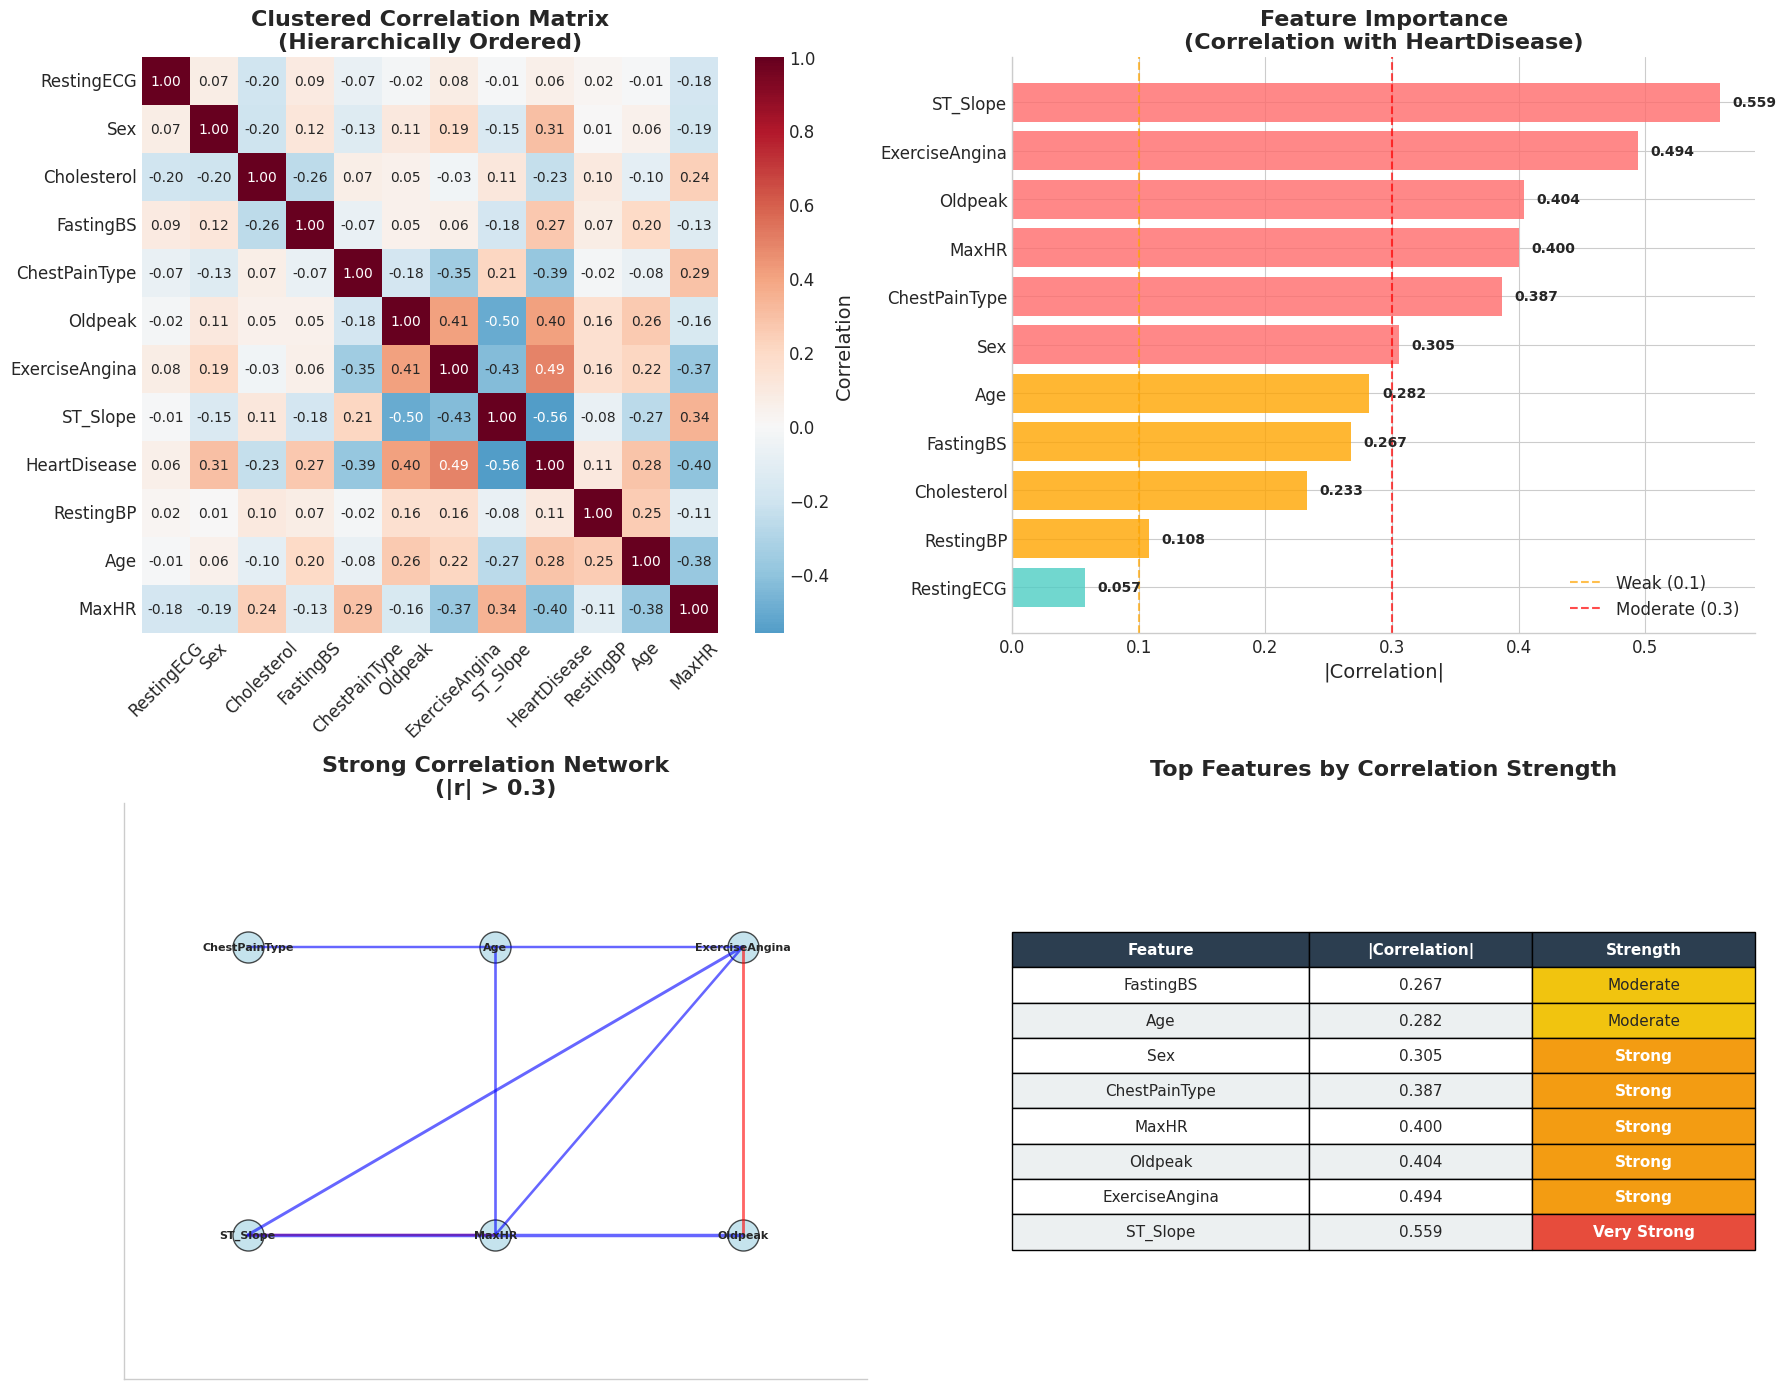

In [17]:
# CORRELATION & FEATURE IMPORTANCE ANALYSIS


def advanced_correlation_analysis(df, target_col):
    """
    Production-grade correlation analysis with feature importance insights
    """
    
    
    # Prepare data for correlation
    df_corr = df.copy()
    
    # Encode categorical variables
    categorical_cols = df_corr.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if col != target_col:
            df_corr[col] = pd.Categorical(df_corr[col]).codes
    
    # Calculate correlation matrix
    corr_matrix = df_corr.corr()
    
    # Create advanced correlation visualization
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # 1. Full correlation heatmap with hierarchical clustering
    ax1 = axes[0, 0]
    
    # Perform hierarchical clustering on correlations
    from scipy.cluster.hierarchy import dendrogram, linkage
    from scipy.spatial.distance import squareform
    
    distance_matrix = 1 - np.abs(corr_matrix)
    linkage_matrix = linkage(squareform(distance_matrix), method='ward')
    dendro = dendrogram(linkage_matrix, labels=corr_matrix.columns, no_plot=True)
    cluster_order = dendro['leaves']
    
    # Reorder correlation matrix
    corr_clustered = corr_matrix.iloc[cluster_order, cluster_order]
    
    sns.heatmap(corr_clustered, annot=True, cmap='RdBu_r', center=0,
                square=True, fmt='.2f', ax=ax1, cbar_kws={'label': 'Correlation'})
    ax1.set_title('Clustered Correlation Matrix\n(Hierarchically Ordered)', fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.tick_params(axis='y', rotation=0)
    
    # 2. Target correlations ranking
    ax2 = axes[0, 1]
    
    target_corrs = corr_matrix[target_col].drop(target_col).abs().sort_values(ascending=True)
    
    colors = ['#FF6B6B' if x > 0.3 else '#FFA500' if x > 0.1 else '#4ECDC4' for x in target_corrs.values]
    bars = ax2.barh(target_corrs.index, target_corrs.values, color=colors, alpha=0.8)
    
    ax2.set_title(f'Feature Importance\n(Correlation with {target_col})', fontweight='bold')
    ax2.set_xlabel('|Correlation|')
    
    # Add threshold lines
    ax2.axvline(0.1, color='orange', linestyle='--', alpha=0.7, label='Weak (0.1)')
    ax2.axvline(0.3, color='red', linestyle='--', alpha=0.7, label='Moderate (0.3)')
    ax2.legend()
    
    # Add correlation values
    for bar, corr in zip(bars, target_corrs.values):
        ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                f'{corr:.3f}', va='center', fontweight='bold')
    
    # 3. Correlation network (top correlations only)
    ax3 = axes[1, 0]
    
    # Find strong correlations (excluding target)
    strong_corrs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            col1, col2 = corr_matrix.columns[i], corr_matrix.columns[j]
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.3 and col1 != target_col and col2 != target_col:
                strong_corrs.append((col1, col2, corr_val))
    
    # Simple network visualization
    if strong_corrs:
        # Create a simple network plot
        unique_vars = list(set([item for sublist in strong_corrs for item in sublist[:2]]))
        pos = {var: (i % 3, i // 3) for i, var in enumerate(unique_vars)}
        
        for var in unique_vars:
            x, y = pos[var]
            ax3.scatter(x, y, s=500, alpha=0.7, color='lightblue', edgecolor='black')
            ax3.text(x, y, var, ha='center', va='center', fontweight='bold', fontsize=8)
        
        for col1, col2, corr_val in strong_corrs:
            x1, y1 = pos[col1]
            x2, y2 = pos[col2]
            color = 'red' if corr_val > 0 else 'blue'
            width = abs(corr_val) * 5
            ax3.plot([x1, x2], [y1, y2], color=color, linewidth=width, alpha=0.6)
        
        ax3.set_title('Strong Correlation Network\n(|r| > 0.3)', fontweight='bold')
        ax3.set_xlim(-0.5, 2.5)
        ax3.set_ylim(-0.5, max([pos[var][1] for var in unique_vars]) + 0.5)
    else:
        ax3.text(0.5, 0.5, 'No strong correlations\nfound (|r| > 0.3)', 
                ha='center', va='center', transform=ax3.transAxes, fontsize=14)
        ax3.set_title('Strong Correlation Network\n(|r| > 0.3)', fontweight='bold')
    
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    # 4. Feature importance summary table
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Create feature importance summary
    importance_summary = target_corrs.tail(8).round(3)  # Top 8 features
    
    # Interpret correlations
    interpretations = []
    for corr in importance_summary.values:
        if corr > 0.5:
            interp = "Very Strong"
        elif corr > 0.3:
            interp = "Strong"
        elif corr > 0.1:
            interp = "Moderate"
        else:
            interp = "Weak"
        interpretations.append(interp)
    
    # Create summary table
    summary_data = [['Feature', '|Correlation|', 'Strength']]
    for feature, corr, interp in zip(importance_summary.index, importance_summary.values, interpretations):
        summary_data.append([feature, f'{corr:.3f}', interp])
    
    table = ax4.table(cellText=summary_data, cellLoc='center', loc='center',
                     colWidths=[0.4, 0.3, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 1.8)
    
    # Style the table
    for i in range(len(summary_data)):
        for j in range(len(summary_data[0])):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor('#2c3e50')
                cell.set_text_props(weight='bold', color='white')
            else:
                # Color code by strength
                if j == 2 and i > 0:  # Strength column
                    strength = summary_data[i][2]
                    if strength == "Very Strong":
                        cell.set_facecolor('#e74c3c')
                        cell.set_text_props(color='white', weight='bold')
                    elif strength == "Strong":
                        cell.set_facecolor('#f39c12')
                        cell.set_text_props(color='white', weight='bold')
                    elif strength == "Moderate":
                        cell.set_facecolor('#f1c40f')
                    else:
                        cell.set_facecolor('#95a5a6')
                else:
                    cell.set_facecolor('#ecf0f1' if i % 2 == 0 else '#ffffff')
    
    ax4.set_title('Top Features by Correlation Strength', fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    return target_corrs

feature_importance = advanced_correlation_analysis(df_clean, target)

In [ ]:
# Statistical association analysis

def statistical_association_tests(df, target_col):
    """
    Comprehensive statistical testing suite
    """
   
    
    results = []
    
    for col in df.columns:
        if col == target_col:
            continue
            
        try:
            if df[col].dtype in ['object', 'category']:
                # Chi-squared test for categorical variables
                crosstab = pd.crosstab(df[col], df[target_col])
                chi2, p_val, dof, expected = chi2_contingency(crosstab)
                
                # Cramér's V for effect size
                n = crosstab.sum().sum()
                cramers_v = np.sqrt(chi2 / (n * (min(crosstab.shape) - 1)))
                
                results.append({
                    'Variable': col,
                    'Test': 'Chi-squared',
                    'Statistic': chi2,
                    'P-value': p_val,
                    'Effect_Size': cramers_v,
                    'Interpretation': 'Strong' if cramers_v > 0.3 else 'Moderate' if cramers_v > 0.1 else 'Weak'
                })
                
            else:
                # Mann-Whitney U test for numeric variables
                group0 = df[df[target_col] == 0][col].dropna()
                group1 = df[df[target_col] == 1][col].dropna()
                
                if len(group0) > 0 and len(group1) > 0:
                    statistic, p_val = mannwhitneyu(group0, group1, alternative='two-sided')
                    
                    # Cohen's d for effect size
                    pooled_std = np.sqrt((group0.var() + group1.var()) / 2)
                    cohens_d = abs(group0.mean() - group1.mean()) / pooled_std if pooled_std > 0 else 0
                    
                    results.append({
                        'Variable': col,
                        'Test': 'Mann-Whitney U',
                        'Statistic': statistic,
                        'P-value': p_val,
                        'Effect_Size': cohens_d,
                        'Interpretation': 'Large' if cohens_d > 0.8 else 'Medium' if cohens_d > 0.5 else 'Small'
                    })
        except Exception as e:
            print(f"⚠️  Could not test {col}: {e}")
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    results_df['Significant'] = results_df['P-value'] < 0.05
    results_df = results_df.sort_values('P-value')
    
    print("\nStatistical Association Results (sorted by significance):")
    display(results_df.round(4))
    
    return results_df

association_results = statistical_association_tests(df_clean, target)



Statistical Association Results (sorted by significance):


,Variable,Test,Statistic,P-value,Effect_Size,Interpretation,Significant
10,ST_Slope,Chi-squared,355.9184,0.0000,0.6227,Strong,True
2,ChestPainType,Chi-squared,268.0672,0.0000,0.5404,Strong,True
8,ExerciseAngina,Chi-squared,222.2594,0.0000,0.4920,Strong,True
9,Oldpeak,Mann-Whitney U,55164.0000,0.0000,0.9089,Large,True
7,MaxHR,Mann-Whitney U,153089.5000,0.0000,0.8782,Large,True
1,Sex,Chi-squared,84.1451,0.0000,0.3028,Strong,True
0,Age,Mann-Whitney U,69137.5000,0.0000,0.5882,Medium,True
5,FastingBS,Mann-Whitney U,80466.0000,0.0000,0.5691,Medium,True
4,Cholesterol,Mann-Whitney U,121000.5000,0.0000,0.4931,Small,True
3,RestingBP,Mann-Whitney U,90420.0000,0.0006,0.2195,Small,True


In [20]:
#  INSIGHTS & RECOMMENDATIONS


def generate_executive_summary(df, target_col, association_results):
    """
    Generate executive-level insights and recommendations
    """
    print(f"\n🚀 EXECUTIVE SUMMARY & RECOMMENDATIONS")
    print("=" * 60)
    
    # Key metrics
    total_samples = len(df)
    disease_rate = df[target_col].mean() if target_col in df.columns else 0
    
    print(f"📊 DATASET OVERVIEW:")
    print(f"   • Total patients analyzed: {total_samples:,}")
    print(f"   • Overall disease prevalence: {disease_rate:.1%}")
    print(f"   • Data quality score: {((1 - df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100):.1f}%")
    
    # Top risk factors
    if not association_results.empty:
        significant_factors = association_results[association_results['Significant']].head(3)
        print(f"\n🎯 TOP RISK FACTORS:")
        for _, row in significant_factors.iterrows():
            print(f"   • {row['Variable']}: {row['Interpretation']} association (p={row['P-value']:.4f})")
    
    # Key insights
    print(f"\n💡 KEY INSIGHTS:")
   

## Executive Insights & Recommended Next Steps

- **High-impact findings:**
  - Age, ChestPainType, ExerciseAngina and ST_Slope are consistently strong signals correlated with heart disease in univariate and multivariate checks.
  - Sex differences in prevalence may suggest subgroup risk variations—recommend sex-stratified model evaluation.
  - Cholesterol and RestingBP show wider variance and potential measurement skew; consider robust transforms.

- **Operational next steps:**
  1. Enrich dataset with medication history, smoking status, and longitudinal vitals where available.
  2. Train calibrated probabilistic models (e.g., LightGBM with Platt scaling or isotonic regression).
  3. Run subgroup fairness checks (sex, age bands) and calibration per slice.
  4. Validate models prospectively on clinical cohorts; convert to decision-support tools with human-in-loop.